In [59]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
import string
import emoji
import optuna

In [60]:
def replace_polish_lowercase(text):
    polish_to_latin = {
        'ą': 'a', 'ć': 'c', 'ę': 'e', 'ł': 'l', 'ń': 'n', 
        'ó': 'o', 'ś': 's', 'ź': 'z', 'ż': 'z'
    }
    return ''.join(polish_to_latin.get(char, char) for char in text)

def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Replace emojis
    text = replace_emojis(text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove polish letters
    text = replace_polish_lowercase(text)
    # Tokenize (split by whitespace)
    tokens = text.split()
    return ' '.join(tokens)  # Join tokens back into a string for TF-IDF

In [61]:
FILENAME_DEV = '/kaggle/input/dataset-conll/all.sentence.dev.txt'
FILENAME_TRAIN = '/kaggle/input/dataset-conll/all.sentence.train.txt'
FILENAME_TEST = '/kaggle/input/dataset-conll/all.sentence.test.txt'

LABELS = {
    "__label__z_minus_m": "Negative sentiment", 
    "__label__z_plus_m": "Positive sentiment",
    "__label__z_zero": "No sentiment",
    "__label__z_amb": "Unsure",
    }


In [62]:
def load_df(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        data = [line.strip() for line in lines]
        # get last word from each item as a label and match with data
        labeled_data = []
        for item in data:
            label = item.split()[-1]
            sentence_data = ' '.join(item.split()[:-1])
            labeled_data.append((sentence_data, LABELS[label]))

        # create a dataframe
        df = pd.DataFrame(labeled_data, columns=['text', 'labels'])
        return df

# Read data

In [63]:
df_train = load_df(FILENAME_TRAIN)
df_test = load_df(FILENAME_TEST)

In [64]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [65]:
df_train.sample(5)

,text,labels
24227,ostatnio pojawilo sie kilka nowosci w menu to ...,Positive sentiment
21194,w daniach bardzo maly wybor miesa przesuszone ...,Negative sentiment
10506,tylko zwiekszymy dawke lekow,Negative sentiment
13867,poszla m na jedna wizyte z kompletem dokumento...,Positive sentiment
1000,i to maja byc cztery gwiazdki pokoje male lazi...,Negative sentiment


# BERT fine tuning

In [66]:
from transformers import (
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
import torch
from torch.utils.data import Dataset
import numpy as np

In [67]:
tokenizer = AutoTokenizer.from_pretrained("dkleczek/bert-base-polish-uncased-v1")
model = AutoModelForSequenceClassification.from_pretrained(
    "dkleczek/bert-base-polish-uncased-v1",
    num_labels=4
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dkleczek/bert-base-polish-uncased-v1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding=True, max_length=max_length)
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [69]:
def prepare_data_for_training(df):
    label_map = {
        'Negative sentiment': 0,
        'No sentiment': 1,
        'Unsure': 2,
        'Positive sentiment': 3
    }
    
    labels = [label_map[label] for label in df['labels']]
    texts = df['text'].tolist()
    
    return texts, labels

In [70]:
def train_classifier(train_df, test_df):
    train_texts, train_labels = prepare_data_for_training(train_df)
    test_texts, test_labels = prepare_data_for_training(test_df)
    
    train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer)
    test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

    def objective(trial):
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
        batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

        training_args = TrainingArguments(
            output_dir="./results_optuna",
            num_train_epochs=1,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            warmup_steps=500,
            weight_decay=0.01,
            learning_rate=learning_rate,
            eval_strategy="epoch",
            save_strategy="epoch",
            load_best_model_at_end=True,
            logging_dir="./logs_optuna",
            report_to=["none"],
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=test_dataset,
        )

        trainer.train()

        eval_results = trainer.evaluate()
        return eval_results["eval_loss"]

    print("Hyperparameter optimalization...")
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=2)

    best_params = study.best_params
    print("Best parameters: ", best_params)

    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=1,
        per_device_train_batch_size=best_params["batch_size"],
        per_device_eval_batch_size=best_params["batch_size"],
        warmup_steps=500,
        weight_decay=0.01,
        learning_rate=best_params["learning_rate"],
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        logging_dir="./logs",
        logging_steps=10,
        report_to=["none"],
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=test_dataset,
    )

    trainer.train()

    return trainer, model, best_params

In [71]:
def predict(texts, model):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt").to('cuda')
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    
    label_map_reverse = {
        0: 'Negative sentiment',
        1: 'No sentiment',
        2: 'Unsure',
        3: 'Positive sentiment'
    }
    
    pred_labels = [label_map_reverse[pred.argmax()] for pred in predictions.detach().numpy()]
    return pred_labels, predictions.detach().cpu().numpy()

In [72]:
trainer, model, best_params = train_classifier(df_train, df_test)

[I 2024-12-18 14:36:49,642] A new study created in memory with name: no-name-d70ca3cc-5c4e-473f-bcab-e64a6816c8b5


Hyperparameter optimalization...


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.675900,0.589749


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

[I 2024-12-18 14:49:26,296] Trial 0 finished with value: 0.5897487998008728 and parameters: {'learning_rate': 2.5527576737724803e-05, 'batch_size': 16}. Best is trial 0 with value: 0.5897487998008728.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.451300,0.584603


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0

[I 2024-12-18 15:00:39,571] Trial 1 finished with value: 0.5846028923988342 and parameters: {'learning_rate': 2.361210956106889e-05, 'batch_size': 32}. Best is trial 1 with value: 0.5846028923988342.


Best parameters:  {'learning_rate': 2.361210956106889e-05, 'batch_size': 32}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.640800,0.694871


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [73]:
model.save_pretrained("/kaggle/working/results")

Accuracy: 0.7791
Confusion matrix:


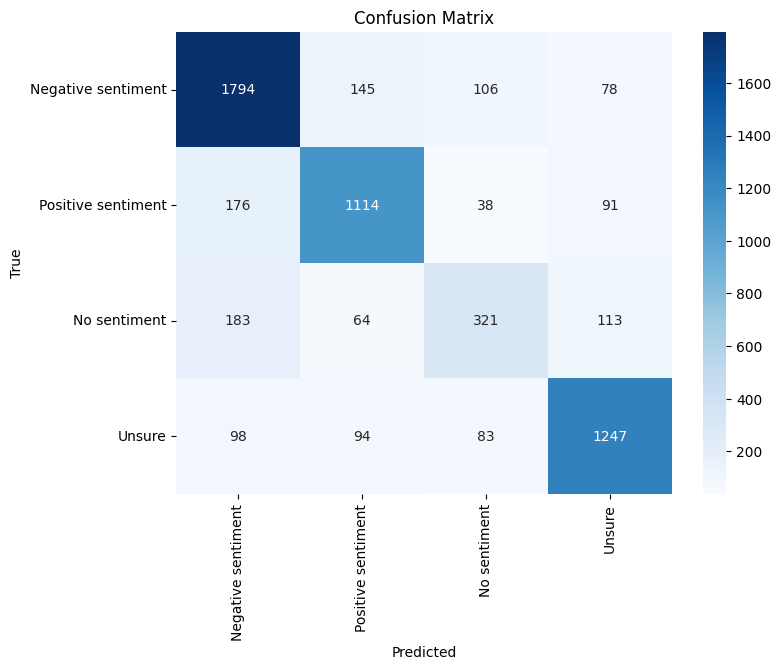

Model Precision: 0.7742
Model Recall: 0.7791
Model F1-Score: 0.7757


In [76]:
test_texts, test_labels = prepare_data_for_training(df_test)
test_dataset = TextClassificationDataset(test_texts, test_labels, tokenizer)

from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torch
import matplotlib.pyplot as plt
import seaborn as sns

test_loader = DataLoader(test_dataset, batch_size=best_params["batch_size"], shuffle=False)

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {key: val.to(model.device) for key, val in batch.items() if key != "labels"}
        labels = batch['labels'].to(model.device)

        # Forward pass
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)

        # Collect predictions and labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy:.4f}")

def plot_confusion_matrix(y_true, y_pred, label_names):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(label_names)))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

# Plot confusion matrix
label_names = list(LABELS.values())
print("Confusion matrix:")
plot_confusion_matrix(all_labels, all_preds, label_names)

# Precision, Recall, F1-score
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f"Model Precision: {precision:.4f}")
print(f"Model Recall: {recall:.4f}")
print(f"Model F1-Score: {f1:.4f}")